In [1]:
# Install if necessary
# !pip install rfflearn

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import rfflearn.cpu as rfflearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [1]:
# Параметры
input_dim = 784  # Размерность входного изображения (28x28)
   # Количество Random Fourier Features
num_classes = 10  # Количество классов MNIST

# Шаг 1: Загрузка данных MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset.data = train_dataset.data[::30]
train_dataset.targets = train_dataset.targets[::30]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset.data = test_dataset.data[::3]
test_dataset.targets = test_dataset.targets[::3]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.35MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
results = dict()

In [9]:
# Experiment loop
hidden_dims = [100, 200, 500, 1000,  1800, 2000, 3500, 4000,  4500, 5000, 10000, 20000, 30000, 40000, 50000] # Example hidden dimensions
train_accuracies = []
test_accuracies = []
train_norms = []
test_norms = []
train_mses = []
test_mses = []

sample_noise = False
stack_train = False

for x, y in train_loader:
  x_train, y_train = x.numpy(), y.numpy()
  if stack_train:
    x_train = np.concatenate((x_train, x_train), axis=0)
    y_train = np.concatenate((y_train, y_train), axis=0)
  if sample_noise:
    num_samples = int(0.3 * len(y_train))
    random_indices = np.random.choice(len(y_train), size=num_samples, replace=False)
    random_samples = y_train[random_indices]
    np.random.shuffle(random_samples)
    y_train[random_indices] = random_samples

y_onehot_train = np.zeros((y_train.shape[0], num_classes))
y_onehot_train[np.arange(len(y_train)), y_train] = 1

for x, y in test_loader:
    x_test, y_test = x.numpy(), y.numpy()

y_onehot_test = np.zeros((y_test.shape[0], num_classes))
y_onehot_test[np.arange(len(y_test)), y_test] = 1

for hidden_dim in hidden_dims:
    rff_reg = rfflearn.RFFRegressor(dim_kernel=hidden_dim).fit(x_train, y_onehot_train)
    pred_train = rff_reg.predict(x_train)
    train_accuracies.append((pred_train.argmax(axis=1) == y_train).mean() * 100)
    train_norms.append(np.linalg.norm(rff_reg.reg.coef_.reshape(-1, 1)))
    train_mses.append(((pred_train - y_onehot_train)**2).sum(axis=1).mean())

    pred_test = rff_reg.predict(x_test)
    test_accuracies.append((pred_test.argmax(axis=1) == y_test).mean() * 100)
    test_norms.append(np.linalg.norm(rff_reg.reg.coef_.reshape(-1, 1)))
    test_mses.append(((pred_test - y_onehot_test)**2).sum(axis=1).mean())

In [10]:
results[0] = (train_accuracies,
test_accuracies,
train_norms,
test_norms,
train_mses,
test_mses )

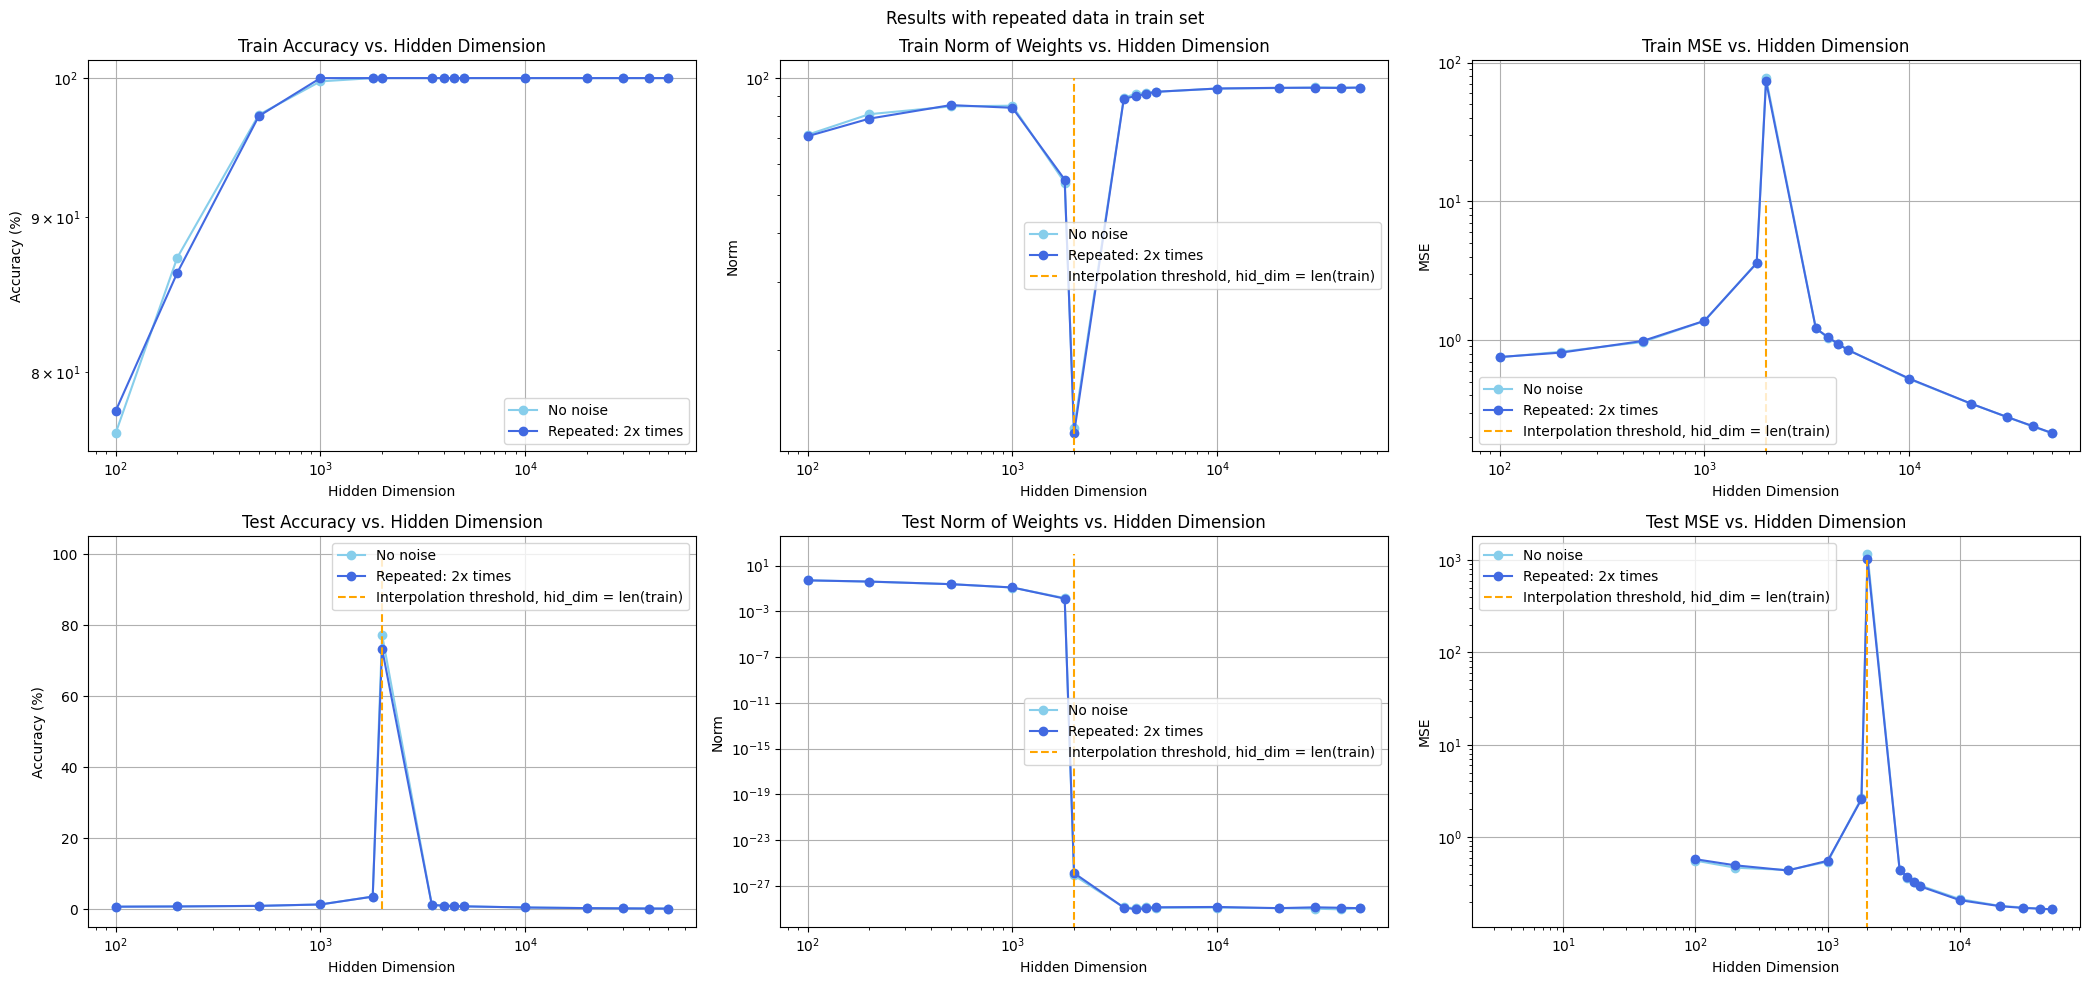

In [11]:
# Plotting
plt.figure(figsize=(21, 10))
plt.suptitle('Results with repeated data in train set')

colors = ['skyblue', 'royalblue', 'mediumblue', 'navy']

plt.subplot(2, 3, 1)
plt.plot(hidden_dims, results[0][0], color=colors[0], label='No noise', marker='o')
plt.plot(hidden_dims, results[2][0], color=colors[1], label='Repeated: 2x times', marker='o')
# plt.plot(hidden_dims, results[20][0], color=colors[2], label='20% noise labels', marker='o')
# plt.plot(hidden_dims, results[30][0], color=colors[3], label='30% noise labels', marker='o')
plt.title("Train Accuracy vs. Hidden Dimension")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Hidden Dimension")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(2, 3, 2)
plt.plot(hidden_dims, results[0][1], color=colors[0], label='No noise', marker='o')
plt.plot(hidden_dims, results[2][1], color=colors[1], label='Repeated: 2x times', marker='o')
# plt.plot(hidden_dims, results[20][1], color=colors[2], label='20% noise labels', marker='o')
# plt.plot(hidden_dims, results[30][1], color=colors[3], label='30% noise labels', marker='o')
plt.title("Train Norm of Weights vs. Hidden Dimension")
plt.vlines(2000, 0, 100, linestyles='dashed', color='orange', label='Interpolation threshold, hid_dim = len(train)')
plt.yscale('log')
plt.legend()
plt.xscale('log')
plt.xlabel("Hidden Dimension")
plt.ylabel("Norm")
plt.grid()

plt.subplot(2, 3, 3)
plt.plot(hidden_dims, results[0][2], color=colors[0], label='No noise', marker='o')
plt.plot(hidden_dims, results[2][2], color=colors[1], label='Repeated: 2x times', marker='o')
# plt.plot(hidden_dims, results[20][2], color=colors[2], label='20% noise labels', marker='o')
# plt.plot(hidden_dims, results[30][2], color=colors[3], label='30% noise labels', marker='o')
plt.title("Train MSE vs. Hidden Dimension")
plt.vlines(2000, 0, 10, linestyles='dashed', color='orange', label='Interpolation threshold, hid_dim = len(train)')
plt.xlabel("Hidden Dimension")
plt.ylabel("MSE")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.subplot(2, 3, 4)
plt.plot(hidden_dims, results[0][3], color=colors[0], label='No noise', marker='o')
plt.plot(hidden_dims, results[2][3], color=colors[1], label='Repeated: 2x times', marker='o')
# plt.plot(hidden_dims, results[20][3], color=colors[2], label='20% noise labels', marker='o')
# plt.plot(hidden_dims, results[30][3], color=colors[3], label='30% noise labels', marker='o')
plt.title("Test Accuracy vs. Hidden Dimension")
plt.xlabel("Hidden Dimension")
plt.vlines(2000, 0, 100, linestyles='dashed', color='orange', label='Interpolation threshold, hid_dim = len(train)')
plt.legend()
plt.xscale('log')
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(2, 3, 5)
plt.plot(hidden_dims, results[0][4], color=colors[0], label='No noise', marker='o')
plt.plot(hidden_dims, results[2][4], color=colors[1], label='Repeated: 2x times', marker='o')
# plt.plot(hidden_dims, results[20][4], color=colors[2], label='20% noise labels', marker='o')
# plt.plot(hidden_dims, results[30][4], color=colors[3], label='30% noise labels', marker='o')
plt.title("Test Norm of Weights vs. Hidden Dimension")
plt.vlines(2000, 0, 100, linestyles='dashed', color='orange', label='Interpolation threshold, hid_dim = len(train)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Hidden Dimension")
plt.ylabel("Norm")
plt.grid()

plt.subplot(2, 3, 6)
plt.plot(hidden_dims, results[0][5], color=colors[0], label='No noise', marker='o')
plt.plot(hidden_dims, results[2][5], color=colors[1], label='Repeated: 2x times', marker='o')
# plt.plot(hidden_dims, results[20][5], color=colors[2], label='20% noise labels', marker='o')
# plt.plot(hidden_dims, results[30][5], color=colors[3], label='30% noise labels', marker='o')
plt.title("Test MSE vs. Hidden Dimension")
plt.xscale('log')
plt.yscale('log')
plt.vlines(2000, 0, 1000, linestyles='dashed', color='orange', label='Interpolation threshold, hid_dim = len(train)')
plt.legend()
plt.xlabel("Hidden Dimension")
plt.ylabel("MSE")
plt.grid()

plt.tight_layout()
plt.show()

In [14]:
def compute_entropy(labels):
    # Получаем распределение классов
    class_counts = np.bincount(labels)
    class_probabilities = class_counts / len(labels)
    # Вычисляем энтропию
    return -np.sum(class_probabilities * np.log2(class_probabilities + 1e-9))  # Добавляем маленькую константу для избегания логарифма от нуля

# Функция для оценки равномерности классов в каждом листе всех деревьев
def evaluate_leaf_uniformity(rf, X):
    leaf_uniformities = []

    # Проходим по каждому дереву в случайном лесе
    for tree in rf.estimators_:
        # Проходим по всем листьям дерева
        for node_id in range(tree.tree_.node_count):
            if tree.tree_.children_left[node_id] == tree.tree_.children_right[node_id]:  # Листовой узел
                # Получаем индексы объектов, попавших в этот лист
                samples_in_leaf = np.where(tree.apply(X) == node_id)[0]
                labels_in_leaf = y[samples_in_leaf]
                # Вычисляем энтропию для этого листа
                entropy = compute_entropy(labels_in_leaf)
                leaf_uniformities.append(entropy)

    return leaf_uniformities

# Оценка равномерности классов в листьях


In [81]:
# Experiment loop
hidden_dims__ = [(20, 1), (20, 5), (20, 10), (20, 50), (20, 100), (20, 500), (20, 1000), (20, 2000), (20, 5000)]#, (20, 10), (20, 10), (20, 10), (20, 10), (20, 10), (20, 10), (20, 10), (20, 10), (20, 10), (20, 10)] # Example hidden dimensions
train_accuracies = []
test_accuracies = []
train_norms = []
test_norms = []
train_mses = []
test_mses = []

for x, y in train_loader:
  x_train, y_train = x.numpy(), y.numpy()

y_onehot_train = np.zeros((y_train.shape[0], num_classes))
y_onehot_train[np.arange(len(y_train)), y_train] = 1

for x, y in test_loader:
    x_test, y_test = x.numpy(), y.numpy()

y_onehot_test = np.zeros((y_test.shape[0], num_classes))
y_onehot_test[np.arange(len(y_test)), y_test] = 1

for n_leaf, n_trees in hidden_dims_:
    rff_reg = RandomForestRegressor(n_estimators=n_trees, max_leaf_nodes=n_leaf).fit(x_train, y_onehot_train)
    pred_train = rff_reg.predict(x_train)
    train_accuracies.append((pred_train.argmax(axis=1) == y_train).mean() * 100)
    train_norms.append(evaluate_leaf_uniformity(rff_reg, x_train))
    train_mses.append(((pred_train - y_onehot_train)**2).sum(axis=1).mean())

    pred_test = rff_reg.predict(x_test)
    test_accuracies.append((pred_test.argmax(axis=1) == y_test).mean() * 100)
    test_norms.append(evaluate_leaf_uniformity(rff_reg, x_train))
    test_mses.append(((pred_test - y_onehot_test)**2).sum(axis=1).mean())

In [82]:
results[1] = (train_accuracies,
test_accuracies,
train_norms,
test_norms,
train_mses,
test_mses )

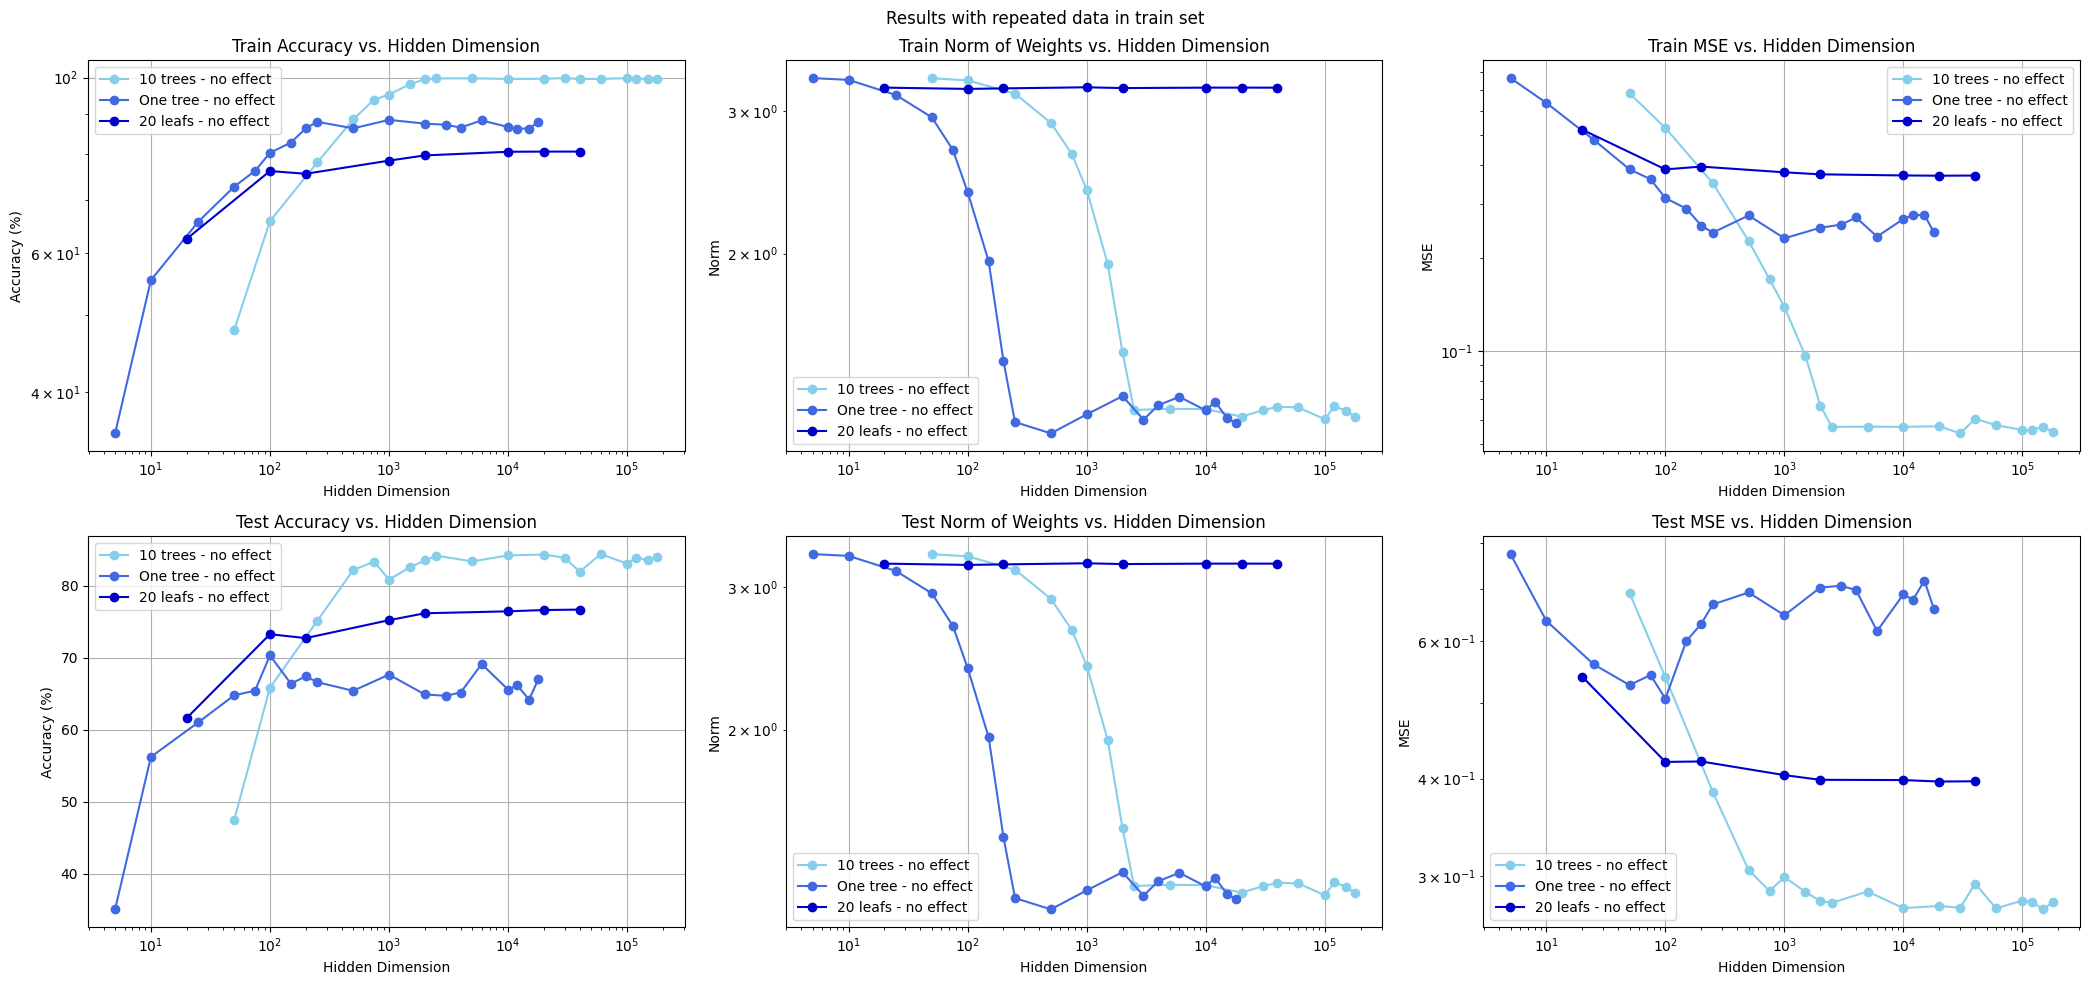

In [84]:
# Plotting
plt.figure(figsize=(21, 10))
plt.suptitle('Results with repeated data in train set')

colors = ['skyblue', 'royalblue', 'mediumblue', 'navy']

plt.subplot(2, 3, 1)
plt.plot([x * y for x, y in hidden_dims_], results[1][0], color=colors[0], label='10 trees - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims], results[2][0], color=colors[1], label='One tree - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims__[:-1]], results[3][0], color=colors[2], label='20 leafs - no effect', marker='o')
plt.title("Train Accuracy vs. Hidden Dimension")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Hidden Dimension")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(2, 3, 2)
plt.plot([x * y for x, y in hidden_dims_], [np.mean(x)for x in results[1][2]], color=colors[0], label='10 trees - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims], [np.mean(x)for x in results[2][2]], color=colors[1], label='One tree - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims__[:-1]], [np.mean(x)for x in results[3][2]], color=colors[2], label='20 leafs - no effect', marker='o')
plt.title("Train Norm of Weights vs. Hidden Dimension")
plt.yscale('log')
plt.legend()
plt.xscale('log')
plt.xlabel("Hidden Dimension")
plt.ylabel("Norm")
plt.grid()

plt.subplot(2, 3, 3)
plt.plot([x * y for x, y in hidden_dims_], results[1][4], color=colors[0], label='10 trees - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims], results[2][4], color=colors[1], label='One tree - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims__[:-1]], results[3][4], color=colors[2], label='20 leafs - no effect', marker='o')
plt.title("Train MSE vs. Hidden Dimension")
plt.xlabel("Hidden Dimension")
plt.ylabel("MSE")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.subplot(2, 3, 4)
plt.plot([x * y for x, y in hidden_dims_], results[1][1], color=colors[0], label='10 trees - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims], results[2][1], color=colors[1], label='One tree - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims__[:-1]], results[3][1], color=colors[2], label='20 leafs - no effect', marker='o')
plt.title("Test Accuracy vs. Hidden Dimension")
plt.xlabel("Hidden Dimension")
plt.legend()
plt.xscale('log')
plt.ylabel("Accuracy (%)")
plt.grid()

plt.subplot(2, 3, 5)
plt.plot([x * y for x, y in hidden_dims_], [np.mean(x)for x in results[1][2]], color=colors[0], label='10 trees - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims], [np.mean(x)for x in results[2][2]], color=colors[1], label='One tree - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims__[:-1]], [np.mean(x)for x in results[3][2]], color=colors[2], label='20 leafs - no effect', marker='o')
plt.title("Test Norm of Weights vs. Hidden Dimension")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Hidden Dimension")
plt.ylabel("Norm")
plt.grid()

plt.subplot(2, 3, 6)
plt.plot([x * y for x, y in hidden_dims_], results[1][5], color=colors[0], label='10 trees - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims], results[2][5], color=colors[1], label='One tree - no effect', marker='o')
plt.plot([x * y for x, y in hidden_dims__[:-1]], results[3][5], color=colors[2], label='20 leafs - no effect', marker='o')
plt.title("Test MSE vs. Hidden Dimension")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("Hidden Dimension")
plt.ylabel("MSE")
plt.grid()

plt.tight_layout()
plt.show()